# Spectra

Explore scalar and directional spectrum observations.

In [1]:
import colorcet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from roguewavespectrum import Spectrum
from roguewavespectrum._directions import convert_angle_convention   # (sorry to use internal modules, Pieter)

from configure import read_stored_variable
from src import buoy_accessor, utilities, plotting

## Setup

Run the previous notebook and read stored variables.

In [2]:
%%capture
# %run 'nb3-overview.ipynb'
%run -i configure.py

In [3]:
microswift_df = read_stored_variable('microswift_df')
spotter_df = read_stored_variable('spotter_df')
ian_spotter_coamps_df = read_stored_variable('ian_spotter_coamps_df')
fiona_spotter_coamps_df = read_stored_variable('fiona_spotter_coamps_df')

plotting.configure_figures()

## Scalar spectra

One dimensional (i.e., scalar wave energy) frequency spectra inside hurricanes are typically unimodal, but can  be bimodal (or even trimodal), particularly on the left side where the wind-sea and swell propagate in different directions (Tamizi et al., 2020).
The high frequency tail of observed hurricane spectra span the range of canonical shapes: in a typical spectrum, the energy just beyond the spectral peak is expected to decay as the frequency power-law f^(-4) characteristic of the equilibrium range (wind input balanced by dissipation from breaking and nonlinear energy fluxes) (Phillips, 1985).
Beyond this range, the spectrum transitions to an f^(-5) saturation range (wind input is balanced by dissipation from breaking) until frequencies approach those of gravity-capillary and capillary waves (Forristall, 1981; Banner, 1990).

Tamizi et al. (2020) fit their hurricane wave observations from buoys to a generalized Joint North Sea Wave Project (JONSWAP) spectral model and find the spectral tail steepens from f^(-4) to f^(-5) with decreasing wave age, where wave age is the ratio of wave phase speed to wind speed. The mean of their slope exponent observations is -4.68. Hwang et al. (2017) find substantial scatter in their observed spectral slopes (between -4 and -5), and instead suggest the treatment of the spectral slope exponent as a random variable.  The Gaussian fit to their data has a mean of -4.48 and standard deviation of 0.53.

Drifting buoy observations suggest the tail becomes dominated by the f^(-5) saturation range above wind speeds of 25 m/s at frequencies spanning the peak frequency to 0.5 Hz (Davis et al., 2023).
Here, the process of binning spectra by wind speed, as described in Davis et al. (2023), is repeated with buoy data from Idalia.


Group Spotter spectra into 10 m/s wide wind speed bins and average.

In [4]:
WIND_SPEED_BIN_SIZE = 10
MINIMUM_BIN_EDGE = 5
MAXIMUM_BIN_EDGE = 55

wind_speed_bins = np.arange(MINIMUM_BIN_EDGE, MAXIMUM_BIN_EDGE+WIND_SPEED_BIN_SIZE, WIND_SPEED_BIN_SIZE)

columns_to_bin = ['wind_speed', 'mean_square_slope_intrinsic', 'energy_density_intrinsic', 'frequency_intrinsic']

# Group spectra by wind speed.
spotter_binned_groupby = spotter_df[columns_to_bin].dropna(axis=0).buoy.bin_by(
    bin_col='wind_speed',
    bins=wind_speed_bins,
    as_index=True,
    group_keys=True,
    observed=True,
)

# Average binned spectra across rows.
spotter_binned_df = spotter_binned_groupby.apply(lambda df: df.buoy.row_average())

# Count spectra in each bin.
spotter_binned_df['count'] = spotter_binned_groupby.count()['wind_speed']


Calculate the normalized, f^4-compensated spectra.  In such a scaling, f^(−4) trends collapse to a constant line.
Also calculate f^5-compensated spectra (f^(−5) trends collapse to a constant line).

In [5]:
spotter_binned_df['energy_density_f4_compensated'] = spotter_binned_df['energy_density_intrinsic'] * spotter_binned_df['frequency_intrinsic']**4
spotter_binned_df['energy_density_f4_compensated_normalized'] = spotter_binned_df['energy_density_f4_compensated'] / spotter_binned_df['energy_density_f4_compensated'].apply(max)
spotter_binned_df['energy_density_f5_compensated'] = spotter_binned_df['energy_density_intrinsic'] * spotter_binned_df['frequency_intrinsic']**5

# Print the binned DataFrame.
spotter_binned_df

,wind_speed,mean_square_slope_intrinsic,energy_density_intrinsic,frequency_intrinsic,count,energy_density_f4_compensated,energy_density_f4_compensated_normalized,energy_density_f5_compensated
wind_speed,,,,,,,,
"(5, 15]",9.169107,0.007650,"[0.005509619881193962, 0.010254480965172784, 0...","[0.029300000000000086, 0.03905999999999989, 0....",260,"[4.060617841859956e-09, 2.3869462474363294e-08...","[2.9029070885785494e-06, 1.7064110565413465e-0...","[1.1897610276649706e-10, 9.323412042486278e-10..."
"(15, 25]",19.318229,0.014813,"[0.04598813105348161, 0.08561311493642797, 0.1...","[0.029300000000000062, 0.03906000000000007, 0....",94,"[3.3893486210720794e-08, 1.9928254206418753e-0...","[1.0952697323665075e-05, 6.439825491982584e-05...","[9.930791459741215e-10, 7.783976093027178e-09,..."
"(25, 35]",28.326076,0.018044,"[0.3921268245591484, 0.6693042068246584, 0.609...","[0.029299999999999996, 0.03905999999999999, 0....",23,"[2.8899946174357365e-07, 1.557946394653593e-06...","[5.849605405747417e-05, 0.00031534216697318835...","[8.467684229086708e-09, 6.085338617516932e-08,..."
"(35, 45]",38.370794,0.019847,"[0.31769550281270104, 0.5753036079139903, 0.61...","[0.0293, 0.03906, 0.04883, 0.05859000000000001...",5,"[2.341431994978845e-07, 1.3391402185159326e-06...","[4.041892076970144e-05, 0.00023116879972508105...","[6.860395745288015e-09, 5.2306816935232325e-08..."
"(45, 55]",50.924514,0.022143,"[0.37700378248472866, 0.717627026083125, 0.810...","[0.0293, 0.03906, 0.04883, 0.05859000000000001...",5,"[2.778537029081604e-07, 1.6704279258849492e-06...","[4.560990747398126e-05, 0.0002742020795265398,...","[8.141113495209099e-09, 6.524691478506612e-08,..."


For each wind speed bin, plot the mean energy density, normalized f^4-compensated mean energy density, and f^5 -compensated mean energy density, all versus frequency.

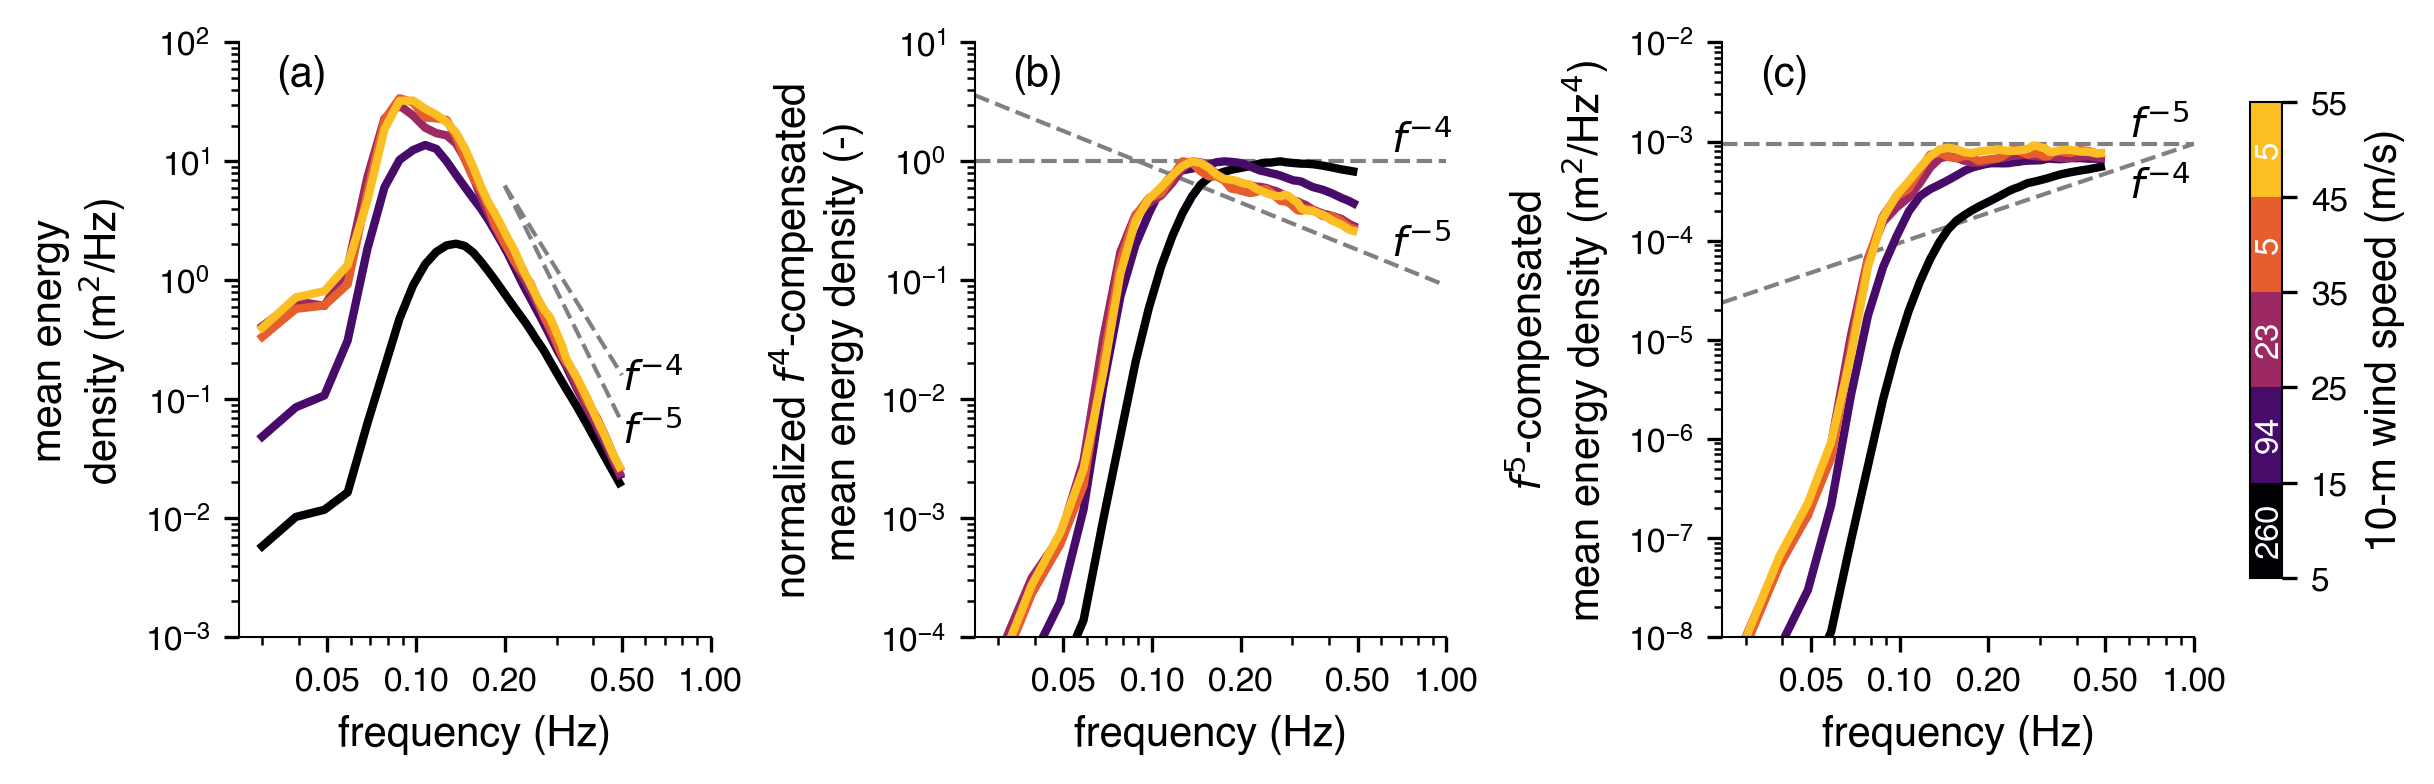

In [6]:
FIG_TITLE = 'afig-spectra_binned_by_wind_speed'
FIG_SIZE = (8, 2.5)

n = len(spotter_binned_df)
cmap = plotting.truncate_colormap(mpl.cm.inferno, 0, 0.85, n)
norm = plt.Normalize(wind_speed_bins[0], wind_speed_bins[-1])
x_limits = np.array([0.025, 1.0])
x_ticks = np.array([5*10**(-2), 0.1, 0.2, 0.5, 1])
label_kwargs = dict(loc='upper left', nudge_x=0.03, nudge_y=0.03)
gs_kwargs = dict(
    width_ratios=[1, 1, 1],
)
color_bar_count_label_kwargs = dict(
    color='w',
    va='center',
    ha='center',
    fontstyle='italic',
    usetex=True,
    fontsize=8,
    rotation='vertical'
)
slope_reference_line_kwargs = dict(
    linestyle='--',
    color='grey',
    linewidth=1,
    zorder=0
)

fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=FIG_SIZE,
    constrained_layout=True,
    gridspec_kw=gs_kwargs,
    sharex=True,
)
labeler = plotting.SubplotLabeler()
axes_iter = plotting.axes_to_iterator(axes)


# Mean energy density versus frequency
ax = next(axes_iter)
lc = plotting.lineplot_color(
    X=np.stack(spotter_binned_df['frequency_intrinsic']),
    Y=np.stack(spotter_binned_df['energy_density_intrinsic']),
    z=np.stack(spotter_binned_df['wind_speed']),
    linewidth=2,
    cmap=cmap,
    norm=norm,
    ax=ax,
)
labeler.add_label(ax, **label_kwargs)

# Plot an f^4 line
ax.plot(np.array([0.2 , 0.5]), 10**(-2)*np.array([0.2 , 0.5])**(-4), **slope_reference_line_kwargs)
ax.annotate('$f^{-4}$', (0.5, 10**(-2.2)*0.5**(-4)), ha='left', va='bottom')

# Plot an f^5 line
ax.plot(np.array([0.2 , 0.490]), 10**(-2.7)*np.array([0.2 , 0.490])**(-5), **slope_reference_line_kwargs)
ax.annotate('$f^{-5}$', (0.5, 10**(-2.95)*0.5**(-5)), ha='left', va='bottom')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(-3), 10**(2)])
ax.set_xlim(x_limits)
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('mean energy\ndensity (m$^2$/Hz)')
plotting.remove_top_and_right_spines(ax)


# Normalized f^4-compensated mean energy density versus frequency
ax = next(axes_iter)
lc = plotting.lineplot_color(
    X=np.stack(spotter_binned_df['frequency_intrinsic']),
    Y=np.stack(spotter_binned_df['energy_density_f4_compensated_normalized']),
    z=np.stack(spotter_binned_df['wind_speed']),
    linewidth=2,
    cmap=cmap,
    norm=norm,
    ax=ax,
)
labeler.add_label(ax, **label_kwargs)

# Plot an f4-compensated a*f^-4 curve (a is a constant)
ax.plot(x_limits, np.ones(np.shape(x_limits)), **slope_reference_line_kwargs)
ax.annotate('$f^{-4}$', (0.65, 1.2),  color='k')

# Plot an f4-compensated a*f^-5 curve (a is a constant)
f_limits = np.array([0.025, 0.95])
ax.plot(f_limits, .09*f_limits**(-1), **slope_reference_line_kwargs)
ax.annotate('$f^{-5}$', (0.65, 0.16), color='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(-4), 10**(1)])
ax.set_xlim(x_limits)
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('normalized $f^4$-compensated\nmean energy density (-)')
plotting.remove_top_and_right_spines(ax)


# f^5-compensated mean energy density versus frequency
ax = next(axes_iter)
lc = plotting.lineplot_color(
    X=np.stack(spotter_binned_df['frequency_intrinsic']),
    Y=np.stack(spotter_binned_df['energy_density_f5_compensated']),
    z=np.stack(spotter_binned_df['wind_speed']),
    linewidth=2,
    cmap=cmap,
    norm=norm,
    ax=ax,
)
labeler.add_label(ax, **label_kwargs)

# Colorbar configuration.
cbar = plt.colorbar(lc, ax=ax, location='right', orientation='vertical', pad=0.05, shrink=0.8, aspect=15)
cbar.set_ticks(wind_speed_bins)
cbar.set_label('10-m wind speed (m/s)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
# Label the colorbar with the number of spectra in each bin.
cbar_annotation_labels = [str(count) for count in spotter_binned_df['count'] ]
cbar_annotation_hz_positions = [0.1, 0.3, 0.5, 0.7, 0.9]
for label, hpos in zip(cbar_annotation_labels, cbar_annotation_hz_positions):
    cbar.ax.text(0.6, hpos, label, transform=cbar.ax.transAxes, **color_bar_count_label_kwargs)

# Plot an f5 compensated a*f^-4 curve (a is a constant)
ax.plot(x_limits, 0.95*10**(-3)*x_limits**(1), **slope_reference_line_kwargs)
ax.annotate('$f^{-4}$', (0.6, 2.7*10**(-4)),  color='k')

# Plot an f5 compensated a*f^-5 curve (a is a constant)
ax.plot(x_limits, 9.5*10**(-4)*x_limits**(0), **slope_reference_line_kwargs)
ax.annotate('$f^{-5}$', (0.6, 1.1 * 10**(-3)), color='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(-8), 10**(-2)])
ax.set_xlim(x_limits)
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('$f^5$-compensated\nmean energy density (m$^2$/Hz$^4$)')
plotting.remove_top_and_right_spines(ax)

# fig.savefig(FIG_TITLE + '.png')


**Appendix Figure**: Hurricane Idalia Spotter spectra in 10 m/s wind speed bins: (a) mean energy density; (b) mean energy density compensated by $f^4$ and normalized by the maximum value in each respective bin; and (c) mean energy density compensated by $f^5$.
Bin counts (number of 1-hour spectra) are labeled inside of the color bar.

When the Doppler-adjusted Idalia data are binned by 10-m wind speed (following prior work), the mean spectra remain dominated by the $f^{-5}$ saturation range at the highest wind speeds.
The $f^{-4}$ equilibrium range is progressively narrowed until it is nearly absent at wind speeds exceeding 25 m/s.
The increase in spectral tail steepness is directly reflected in the change in mss: mss integrated over a largely saturated spectrum with $E(f) \sim c_s f^{-5}$ has only logarithmic contributions to mss with increasing frequency, whereas the contributions of equilibrium range with $E(f) \sim c_e f^{-4}$ are linear in frequency ($c_s$ and $c_e$ are constants related to the spectral energy levels).

## Directional spectra

Estimate directional energy density spectra, $E(f, \varphi)$ (Where $\varphi$ is  spectral wave direction), using the Maximum Shannon Entropy Method (MEM-II) (Kobune and Hashimoto, 1986; Christie, 2024).  The MEM-II implementation used here is from the Rogue Wave Spectrum package (https://github.com/sofarocean/oceanwavespectrum).

In [7]:
def spectra_2d_from_df(drifter_df: pd.DataFrame) -> Spectrum:
    """ Return a 2D directional spectrum from a DataFrame of drifter data. """
    dataset_variables = [
        'energy_density_intrinsic',
        'frequency_intrinsic',
        'a1', 'b1', 'a2', 'b2',
        'mean_square_slope_intrinsic',
        'depth',
        'mean_direction',
        'wind_direction',
        'wind_speed',
        'storm_heading',
    ]
    variable_name_mapping = {
        'energy_density_intrinsic': 'variance_density',
        'frequency_intrinsic': 'frequency',
    }

    # Convert the DataFrame to an xarray dataset
    drifter_ds = (drifter_df
                  .loc[:, dataset_variables]
                  .buoy.to_xarray(frequency_col='frequency_intrinsic')
                  .astype(float))

    # Create a Spectrum object and compute the directional spectrum.
    drfiter_spectra_1d = Spectrum.from_dataset(drifter_ds, mapping=variable_name_mapping)
    drifter_spectra_2d = drfiter_spectra_1d.as_frequency_direction_spectrum(
        number_of_directions=720,
        method="mem2",
        solution_method="scipy"
    )
    return drifter_spectra_2d

Compute directional spectra using MEM-II (this may take a few seconds).

In [8]:
spotter_spectra_2d = spectra_2d_from_df(spotter_df)

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|          | 0/4800 [00:00<?, ?it/s]

In [9]:
microswift_spectra_2d = spectra_2d_from_df(microswift_df)

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|          | 0/216 [00:00<?, ?it/s]

Calculate the slope spectrum, which describes the contribution of each wavelength (frequency) and direction to mss
\begin{equation}
    S(k, \varphi) = E(k, \varphi) k^2
\end{equation}
Where $E(k, \varphi)$ is the directional energy spectrum, as a function of wavenumber, calculated from transforming $E(f, \varphi)$ by the Jacobian $df / dk = c_g / (2\pi)$.  In the deep water limit, the slope spectrum is calculated from the directional frequency spectrum as
\begin{equation}
    S(f, \varphi) = \frac{(2 \pi f)^4 E(f, \varphi)}{g^2}
\end{equation}


Calculate the slope spectrum from the wavenumber directional energy spectrum.

In [10]:
def calculate_slope_spectra(drifter_spectra_2d):
    directional_energy_density = drifter_spectra_2d.directional_variance_density
    wavenumber = drifter_spectra_2d.wavenumber
    dim_to_reduce = spotter_spectra_2d.wavenumber.dims[:-1]
    wavenumber = wavenumber.mean(dim=dim_to_reduce)
    directional_energy_density = (directional_energy_density
                                  .assign_coords({'wavenumber': wavenumber}))
    jacobian =  drifter_spectra_2d.groupspeed / (2 * np.pi)
    directional_wavenumber_energy_density = directional_energy_density * jacobian
    return directional_wavenumber_energy_density * wavenumber**2

In [11]:
spotter_spectra_2d.dataset['directional_slope_spectrum'] = calculate_slope_spectra(
    spotter_spectra_2d
)
microswift_spectra_2d.dataset['directional_slope_spectrum'] = calculate_slope_spectra(
    microswift_spectra_2d
)

Create a figure to compare directional slope spectra by storm quadrant for four representative buoys.
Observations in each quadrant are from unique buoys between 2 RMW to 4 RMW from Idalia's center and are collected within a three-hour span.

In [12]:
def plot_2d_spectrum(ax, energy_density, frequency, direction, **kwargs):
    """ Plot a 2D directional spectrum on polar-projected axes. """
    im = ax.contourf(
        direction,
        frequency,
        energy_density,
        **kwargs
    )
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid('on')

    return im


def plot_2d_slope_spectrum(
    ax,
    drifter_spectra_2d,
    plot_colorbar=True,
    cbar_kwargs=None,
    cax=None,
    storm_frame=False,
    include_azimuth_ticks=True,
    label_radials=True,
):
    """ Plot a 2D directional slope energy density spectrum. """
    if cbar_kwargs is None:
        cbar_kwargs = dict()

    # Colormap and normalization
    vmin_exp = -4.5  # -6
    vmax_exp = -2.5  # -4
    num_levels = 5  # 9
    norm = mpl.colors.LogNorm(vmin=10**(vmin_exp), vmax=10**(vmax_exp))
    levels = np.geomspace(10**(vmin_exp), 10**(vmax_exp), num=num_levels)
    cmap = colorcet.cm.CET_L17
    cmap.set_under('w')
    cmap.set_over('k')
    slope_spectrum_kwargs = dict(
        cmap=cmap,
        norm=norm,
        levels=levels,
        extend='both',
    )

    # Spectra and direction variables
    drifter_spectra_2d = drifter_spectra_2d.drop_invalid()
    slope_spectrum = drifter_spectra_2d.dataset.directional_slope_spectrum.values.squeeze()
    frequency = drifter_spectra_2d.frequency.values.squeeze()
    direction_rad_to = np.deg2rad(drifter_spectra_2d.direction(directional_convention='oceanographical')).values.squeeze()
    wave_direction_rad_to = np.deg2rad(-180 + drifter_spectra_2d.dataset['mean_direction'].values.squeeze())
    wind_direction_rad_to = np.deg2rad(-180 + drifter_spectra_2d.dataset['wind_direction'].values.squeeze())

    if storm_frame:
        storm_heading_rad = np.deg2rad(drifter_spectra_2d.dataset['storm_heading'].values.squeeze())
        direction_rad_to -= storm_heading_rad
        wave_direction_rad_to -= storm_heading_rad
        wind_direction_rad_to -=storm_heading_rad

    # Spectrum contour
    im = plot_2d_spectrum(
        ax,
        energy_density=slope_spectrum,
        frequency=frequency,
        direction=direction_rad_to,
        **slope_spectrum_kwargs
    )
    ax.yaxis.grid(linewidth=0.5, alpha=0.2)
    ax.xaxis.grid(linewidth=0.5, alpha=0.2)  # ax.xaxis.grid(False)

    if include_azimuth_ticks:
        ax.tick_params(axis='x', which='major', pad=-2, labelsize=plotting.small_font_size)
        ax.tick_params(axis='y', labelsize=plotting.small_font_size)  # labelrotation=-90
        ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
    else:
        ax.set_xticklabels('')

    r_label_position = 125
    ax.set_rlabel_position(r_label_position)
    if label_radials:
        ax.text(
            np.radians(r_label_position-30),
            ax.get_rmax()/2.,
            '     frequency (Hz)',
            rotation=-37,
            ha='center',
            va='center',
            fontsize=plotting.small_font_size,
        )

    if plot_colorbar:
        fmt = mpl.ticker.LogFormatterMathtext(base=10.0, labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
        cbar=plt.colorbar(im, cax=cax, **cbar_kwargs, format=fmt)
        cbar.set_label(
            # 'slope spectral\ndensity (1/Hz/rad)',  #(going to)
            'slope spectral density\n(m$\mathregular{^2}$/deg $\cdot$ rad/m)',  #(going to)
            fontsize=plotting.small_font_size,
            usetex=False
        )

    else:
        cbar=None

    # Directions
    wave_color = 'deepskyblue'
    head_width=0
    head_length=0
    ax.arrow(wave_direction_rad_to, 0, 0, 0.25, label='wave direction', head_width=head_width, head_length=head_length, fc=wave_color, ec=wave_color)
    ax.arrow(wind_direction_rad_to, 0, 0, 0.25, label='wind direction', head_width=head_width, head_length=head_length, fc='k', ec='k')

    return im, cbar


def annotate_spectrum_by_quadrant(
    ax,
    drifter_df,
    quadrant,
    include_variable_name=True,
    **kwargs
):
    """ Annotate a spectrum plot with the hurricane quadrant name. """
    mean_square_slope = drifter_df['mean_square_slope_intrinsic'].squeeze()
    wind_speed = drifter_df['wind_speed'].squeeze()
    if quadrant == 'front_left':
        label='Left-Front'
        xy=(-0.25, 1)
        ha='left'
        va='top'
    elif quadrant == 'front_right':
        label='Right-Front'
        xy=(1.25, 1)
        ha='right'
        va='top'
    elif quadrant == 'rear_left':
        label='Left-Rear'
        xy=(-0.25, 0)
        ha='left'
        va='bottom'
    elif quadrant == 'rear_right':
        label='Right-Rear'
        xy=(1.25, 0)
        ha='right'
        va='bottom'
    if include_variable_name:
        text = (
            f'{label}\n'
            f'mss = {mean_square_slope:.3f}\n'
            f'U10 = {wind_speed:.0f} m/s'
        )
    else:
        text = (
            f'{label}\n'
            f'{mean_square_slope:.3f}\n'
            f'{wind_speed:.0f} m/s'
        )
    ax.annotate(
        text=text,
        xy=xy,
        ha=ha,
        va=va,
        xycoords='axes fraction',
        fontsize=plotting.small_font_size,
        **kwargs,
    )


def create_storm_center_map(ax):
    """ Create a simple, storm-centered map to draw buoy locations on. """
    # Center spines
    ax.spines[['left', 'bottom']].set_position(("data", 0))  # .set_position('center')
    ax.spines[['top', 'right']].set_visible(False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    ax.tick_params(direction='inout', length=2, width=0.5)
    ax.set_facecolor('none')
    ax.set_aspect('equal')

    # Set limits and labels
    ax.set_xlim(4*np.array([-1, 1]))
    ax.set_ylim(4*np.array([-1, 1]))
    ax.set_xticks(4*np.array([-1, -0.5, 0.5, 1]))
    ax.set_yticks(4*np.array([-1, -0.5, 0.5, 1]))
    ax.set_xticklabels(['', '', '', ''])
    ax.set_yticklabels(['', '', '2', '4'])
    ax.tick_params(axis='y', which='major', pad=-9, labelsize=plotting.small_font_size)
    ax.set_ylabel('y/RMW', rotation="horizontal", ha='center', va='bottom', fontsize=plotting.small_font_size)
    ax.yaxis.set_label_coords(0.5, 1.05)
    ax.set_xlabel('x/RMW', rotation="horizontal", ha='left', va='center', fontsize=plotting.small_font_size)
    ax.xaxis.set_label_coords(1.05, 0.5)

    # Draw circlular gridlines
    circle_kwargs = dict(color='k', alpha=0.2, linewidth=0.5, fill=False, clip_on=False, zorder=0)
    circle_2rmw = plt.Circle((0, 0), 2, **circle_kwargs)
    circle_4rmw = plt.Circle((0, 0), 4, **circle_kwargs)
    ax.add_patch(circle_2rmw)
    ax.add_patch(circle_4rmw)

    plotting.plot_hurricane_symbol(ax=ax)
    return ax


<>:96: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\m'
/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_28584/1593242024.py:96: SyntaxWarning: invalid escape sequence '\m'
  'slope spectral density\n(m$\mathregular{^2}$/deg $\cdot$ rad/m)',  #(going to)


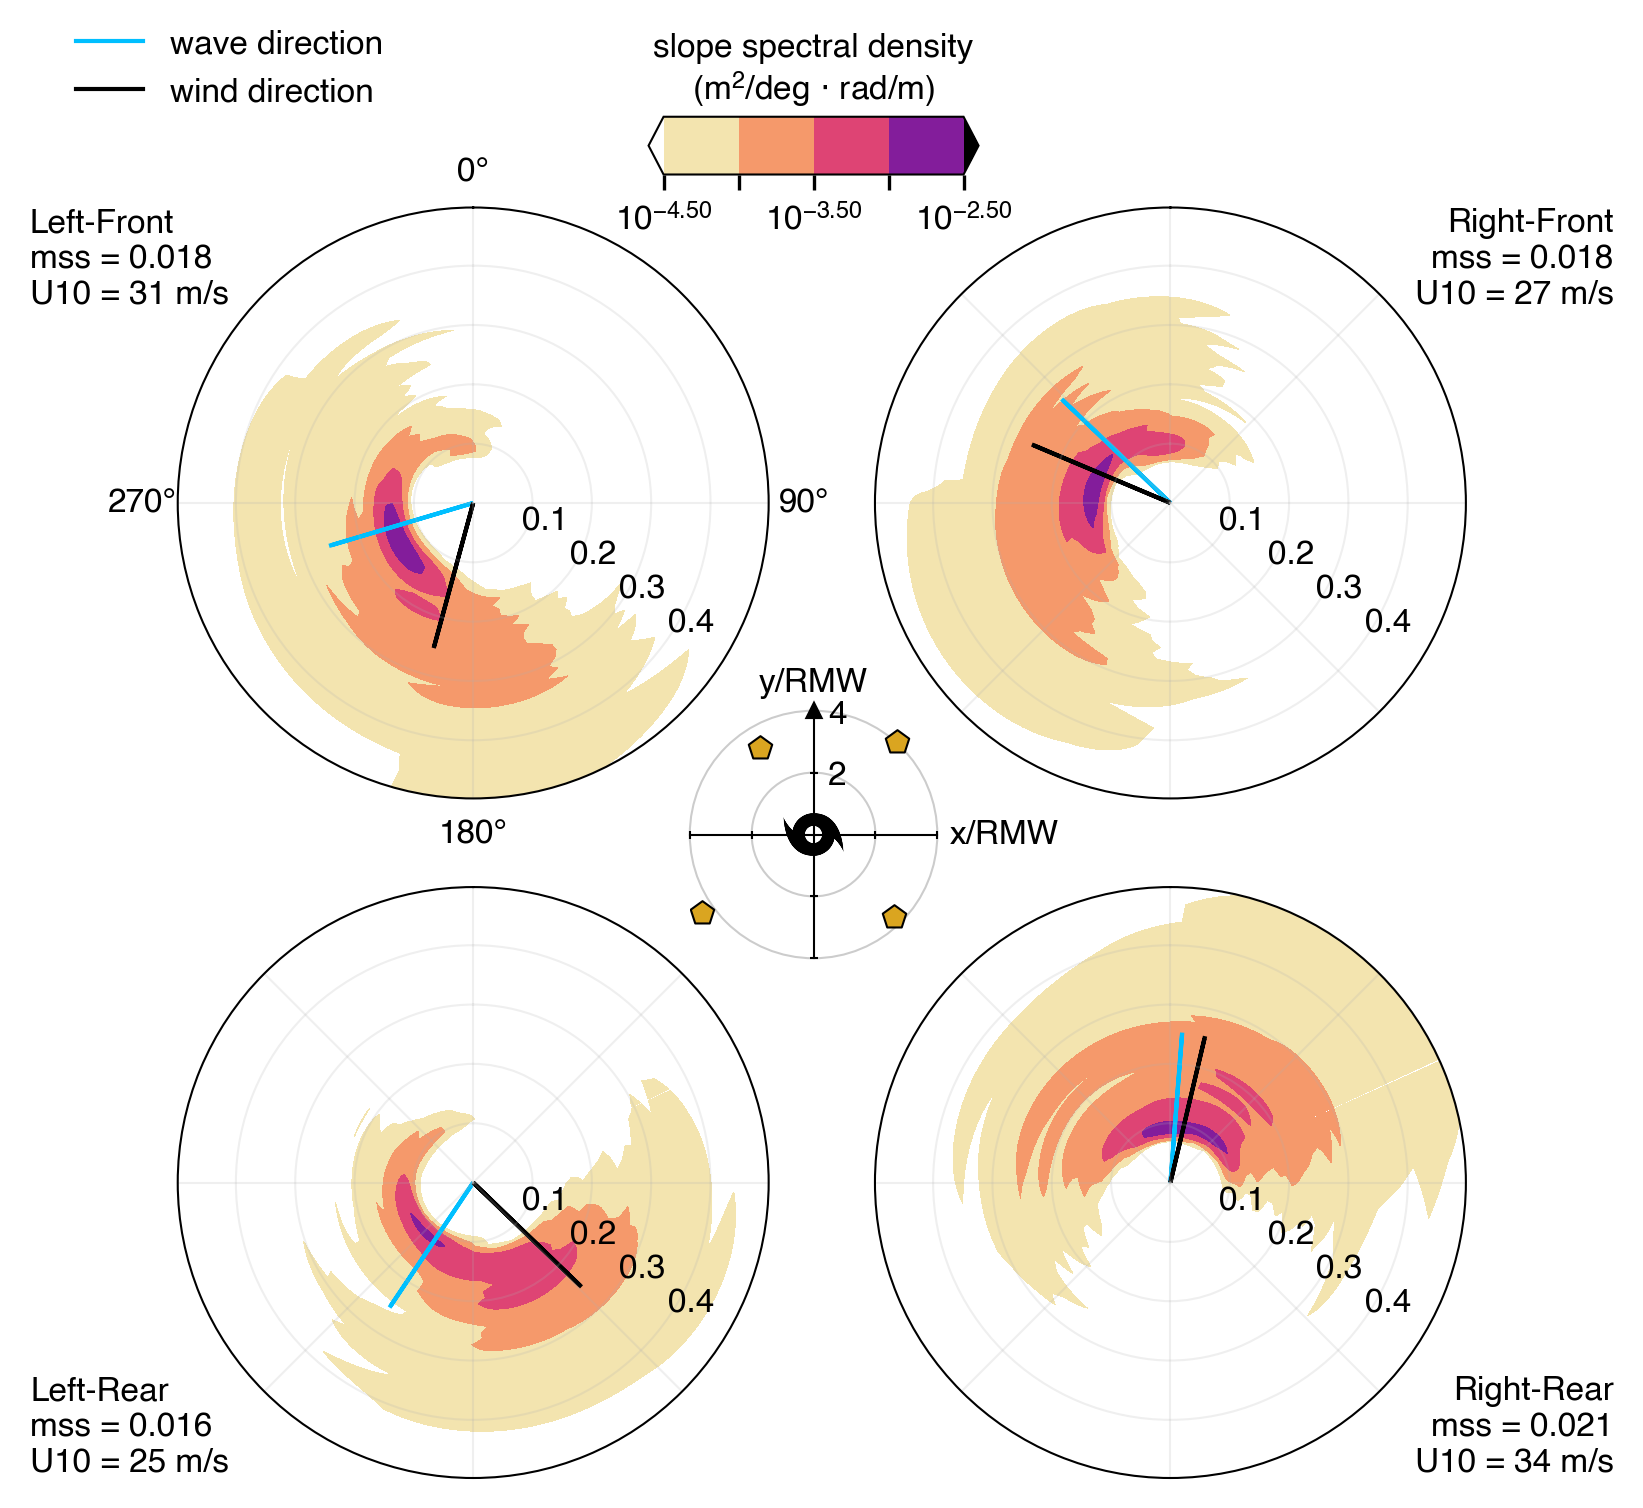

In [13]:
FIG_SIZE = (5.5, 5.5)

map_kwargs = plotting.spotter_map_kwargs
cbar_kwargs = {'orientation': 'horizontal'}
gridspec_kw = {
    'height_ratios': [1, 1],
    'hspace': 0.15,
    'wspace': 0.15,
    'left': 0.11,
}

fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), gridspec_kw=gridspec_kw, figsize=FIG_SIZE)
cax = fig.add_axes([0.4, 0.90, 0.2, 0.035])  # left, bottom, width, height

# Create axes for a storm-centered map in the center
ax_map = fig.add_axes([0.425, 0.425, 0.15, 0.15])
ax_map = create_storm_center_map(ax_map)

# Front left quadrant
spotter_id = 'SPOT-30095D'
time_slice = utilities.create_time_slice(pd.Timestamp('2023-08-30 08:00:00', tz='utc'))
time_slice_no_tz = utilities.strip_time_slice_tz(time_slice)
plot_2d_slope_spectrum(
    ax[0,0],
    spotter_spectra_2d.sel(id=spotter_id, time=time_slice_no_tz),
    storm_frame=True,
    plot_colorbar=True,
    cbar_kwargs=cbar_kwargs,
    cax=cax,
    include_azimuth_ticks=True,
    label_radials=False,
)
annotate_spectrum_by_quadrant(ax[0,0], spotter_df.loc[(spotter_id, time_slice), :], quadrant='front_left', include_variable_name=True)
plotting.plot_drifter_storm_frame(spotter_df.loc[(spotter_id, time_slice), :], ax_map, **map_kwargs)

# Front right quadrant
spotter_id = 'SPOT-30102D'
time_slice = utilities.create_time_slice(pd.Timestamp('2023-08-30 07:00:00', tz='utc'))
time_slice_no_tz = utilities.strip_time_slice_tz(time_slice)
plot_2d_slope_spectrum(
    ax[0,1],
    spotter_spectra_2d.sel(id=spotter_id, time=time_slice_no_tz),
    storm_frame=True,
    plot_colorbar=False,
    include_azimuth_ticks=False,
    label_radials=False,
)
annotate_spectrum_by_quadrant(ax[0,1], spotter_df.loc[(spotter_id, time_slice), :], quadrant='front_right', include_variable_name=True)
plotting.plot_drifter_storm_frame(spotter_df.loc[(spotter_id, time_slice), :], ax_map, **map_kwargs)

# Rear left quadrant
spotter_id = 'SPOT-30164D'
time_slice = utilities.create_time_slice(pd.Timestamp('2023-08-30 09:00:00', tz='utc'))
time_slice_no_tz = utilities.strip_time_slice_tz(time_slice)
plot_2d_slope_spectrum(
    ax[1,0],
    spotter_spectra_2d.sel(id=spotter_id, time=time_slice_no_tz),
    storm_frame=True,
    plot_colorbar=False,
    include_azimuth_ticks=False,
    label_radials=False,
)
annotate_spectrum_by_quadrant(ax[1,0], spotter_df.loc[(spotter_id, time_slice), :], quadrant='rear_left', include_variable_name=True)
plotting.plot_drifter_storm_frame(spotter_df.loc[(spotter_id, time_slice), :], ax_map, **map_kwargs)

# Rear right quadrant
spotter_id = 'SPOT-30101D'
time_slice = utilities.create_time_slice(pd.Timestamp('2023-08-30 08:00:00', tz='utc'))
time_slice_no_tz = utilities.strip_time_slice_tz(time_slice)
plot_2d_slope_spectrum(
    ax[1,1],
    spotter_spectra_2d.sel(id=spotter_id, time=time_slice_no_tz),
    storm_frame=True,
    plot_colorbar=False,
    include_azimuth_ticks=False,
    label_radials=False,
)
annotate_spectrum_by_quadrant(ax[1,1], spotter_df.loc[(spotter_id, time_slice), :], quadrant='rear_right', include_variable_name=True)
plotting.plot_drifter_storm_frame(spotter_df.loc[(spotter_id, time_slice), :], ax_map, **map_kwargs)

# Update spectrum colorbar
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')
for label in cax.get_xticklabels()[1::2] :
            label.set_visible(False)

# Custom legend for wind and wave directions
custom_lines = [
    mpl.lines.Line2D([0], [0], color='deepskyblue', lw=1, label='wave direction'),
    mpl.lines.Line2D([0], [0], color='k', lw=1, label='wind direction')
]
ax[0,0].legend(handles=custom_lines, frameon=False, bbox_to_anchor=[-0.2, 1.33], loc='upper left', borderpad=0)

## Mean square slope components (down and cross wind) 

Down-wind and cross-wind mss components describe slope energy projected along and perpendicular to wind direction, respectively.
After the directional slope spectrum is rotated such that wind direction is aligned with the positive x-axis, the down- and cross-wind mss are the components along each axis (Elfouhaily, 1997)
\begin{equation}
    \mathrm{mss_{down}} = \int_{f_1}^{f_2} \int_{0}^{2\pi} \cos^2(\varphi) S(k, \varphi) d\varphi dk
\end{equation}
and
\begin{equation}
    \mathrm{mss_{cross}} = \int_{f_1}^{f_2} \int_{0}^{2\pi} \sin^2(\varphi) S(k, \varphi) d\varphi dk
\end{equation}
where $\varphi$ is defined in the mathematical convention: $0\degree$ is aligned with the positive x-axis (wind direction), directions indicate ``going to'', and values are measured positive counterclockwise.
By definition, $\mathrm{mss} = \mathrm{mss_{down}} + \mathrm{mss_{cross}}$.

In [14]:
def down_cross_mean_square_slope(drifter_spectra_2d):
    """ Return down- and cross-wind mss from a 2D directional spectra. """
    directional_slope_spectrum = drifter_spectra_2d.dataset.directional_slope_spectrum
    direction_deg =  drifter_spectra_2d.direction()

    # Rotate directions to be relative to the wind direction (wind is + x-axis)
    wind_direction_deg_met = drifter_spectra_2d.dataset['wind_direction'].squeeze()
    wind_direction_deg_math = convert_angle_convention(angle=wind_direction_deg_met, to_convention='mathematical', from_convention='meteorological', units='degree')
    direction_rel_wind_deg = direction_deg - wind_direction_deg_math

    # Calculate projected slopes
    cos_dir = np.cos(np.deg2rad(direction_rel_wind_deg))
    sin_dir = np.sin(np.deg2rad(direction_rel_wind_deg))
    mss_x = (cos_dir**2 * directional_slope_spectrum).integrate(coord='direction').integrate(coord='wavenumber')
    mss_y = (sin_dir**2 * directional_slope_spectrum).integrate(coord='direction').integrate(coord='wavenumber')
    return mss_x, mss_y

def mss_da_to_series(mss_da):
    """ Convert a DataArray of mean square slope to a Series. """
    mss_series = (mss_da
                  .to_series()
                  .dropna()
                  .tz_localize('UTC', level='time'))
    return mss_series

Calculate down- and cross-wind mean square slope and merge into to the original drifter DataFrames.  These will be plotted in a subsequent notebook.


In [15]:
mss_x, mss_y = down_cross_mean_square_slope(
    drifter_spectra_2d=spotter_spectra_2d,
)
spotter_df['mean_square_slope_intrinsic_down_wind'] = mss_da_to_series(mss_x)
spotter_df['mean_square_slope_intrinsic_cross_wind'] = mss_da_to_series(mss_y)
spotter_df['mean_square_slope_intrinsic_ratio'] = spotter_df['mean_square_slope_intrinsic_cross_wind'] / spotter_df['mean_square_slope_intrinsic_down_wind']

In [16]:
mss_x, mss_y = down_cross_mean_square_slope(
    drifter_spectra_2d=microswift_spectra_2d,
)
microswift_df['mean_square_slope_intrinsic_down_wind'] = mss_da_to_series(mss_x)
microswift_df['mean_square_slope_intrinsic_cross_wind'] = mss_da_to_series(mss_y)
microswift_df['mean_square_slope_intrinsic_ratio'] = microswift_df['mean_square_slope_intrinsic_cross_wind'] / microswift_df['mean_square_slope_intrinsic_down_wind']

Store the directional spectra and updated Spotter and MicroSWIFT DataFrames.

In [17]:
%store spotter_spectra_2d
%store microswift_spectra_2d
%store spotter_df
%store microswift_df

Stored 'spotter_spectra_2d' (Spectrum)
Stored 'microswift_spectra_2d' (Spectrum)
Stored 'spotter_df' (DataFrame)
Stored 'microswift_df' (DataFrame)


## References

Banner, M. L. (1990). Equilibrium spectra of wind waves. https://doi.org/10.1175/1520-0485(1990)020<0966:ESOWW>2.0.CO;2

Christie, D. C. (2024). Efficient estimation of directional wave buoy spectra using a reformulated Maximum Shannon Entropy Method: Analysis and comparisons for coastal wave datasets. Applied Ocean Research, 142, 103830. https://doi.org/10.1016/j.apor.2023.103830

Davis, J. R., Thomson, J., Houghton, I. A., Doyle, J. D., Komaromi, W. A., Fairall, C. W., Thompson, E. J., & Moskaitis, J. R. (2023). Saturation of Ocean Surface Wave Slopes Observed During Hurricanes. Geophysical Research Letters, 50(16), e2023GL104139. https://doi.org/10.1029/2023GL104139

Elfouhaily, T., Chapron, B., Katsaros, K., & Vandemark, D. (1997). A unified directional spectrum for long and short wind-driven waves. Journal of Geophysical Research: Oceans, 102(C7), 15781–15796. https://doi.org/10.1029/97JC00467

Forristall, G. Z. (1981). Measurements of a saturated range in ocean wave spectra. Journal of Geophysical Research, 86(C9), 8075. https://doi.org/10.1029/JC086iC09p08075

Hwang, P. A., Fan, Y., Ocampo-Torres, F. J., & García-Nava, H. (2017). Ocean Surface Wave Spectra inside Tropical Cyclones. Journal of Physical Oceanography, 47(10), 2393–2417. https://doi.org/10.1175/JPO-D-17-0066.1

Kobune, K., & Hashimoto, N. (1986). Estimation of directional spectra from the maximum entropy principle. 80–85.

Phillips, O. M. (1985). Spectral and statistical properties of the equilibrium range in wind-generated gravity waves. Journal of Fluid Mechanics, 156(1), 505. https://doi.org/10.1017/S0022112085002221

Tamizi, A., & Young, I. R. (2020). The Spatial Distribution of Ocean Waves in Tropical Cyclones. Journal of Physical Oceanography, 50(8), 2123–2139. https://doi.org/10.1175/JPO-D-20-0020.1

